Loan Prediction practice

Date: March 03, 2017

Project Description:
Company wants to automate the loan eligibility process (real time) based on customer detail provided
while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents,
Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the 
customers segments, those are eligible for loan amount so that they can specifically target these customers.Here they have provided a partial data set.

Part 2: Using Logistic regression to make loan prediction without imputation


In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score,auc

In [2]:
data=pd.read_csv('train_data.csv')
display(data.head(1))
print "Training dataset has {} samples with {} features.".format(*data.shape)

train_features=data.drop(['Loan_Status'],1)
train_labels=data['Loan_Status']

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


Training dataset has 614 samples with 13 features.


Data Processing:

In [3]:
#Create dummy variables for categorical variables
dummies = pd.get_dummies(train_features['Property_Area'], prefix='Property_Area')
train_features_recode=train_features.join(dummies).drop(['Property_Area','Property_Area_Rural'],1)

In [4]:
#Check missing values for all variables
def num_missing(x):
    return sum(x.isnull())

data.apply(num_missing,axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
#Coding LoanStatus as Y=1, N=0:
#Create a generic function to recode variables using replace function:
def coding(col, coldict):
    colnew=pd.Series(col, copy=True)
    for key, value in coldict.items():
        colnew.replace(key, value, inplace=True) 
    return colnew

train_features_recode['Gender_coded']=coding(train_features_recode['Gender'],{'Male':0,'Female':1})
train_features_recode['Married_coded']=coding(train_features_recode['Married'],{'Yes':0,'No':1})
train_features_recode['Education_coded']=coding(train_features_recode['Education'],{'Not Graduate':0,'Graduate':1})
train_features_recode['Self_Employed_coded']=coding(train_features_recode['Self_Employed'],{'Yes':0,'No':1})
train_features_recode['Dependents_coded']=coding(train_features_recode['Dependents'],{'0':0,'1':1,'2':2,'3+':3})
train_features_recode.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Semiurban,Property_Area_Urban,Gender_coded,Married_coded,Education_coded,Self_Employed_coded,Dependents_coded
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,0.0,1.0,0.0,1.0,1,1.0,0.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,0.0,0.0,0.0,0.0,1,1.0,1.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,0.0,1.0,0.0,0.0,1,0.0,0.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,0.0,1.0,0.0,0.0,0,1.0,0.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,0.0,1.0,0.0,1.0,1,1.0,0.0


In [6]:
train_features_recode2= train_features_recode[(train_features_recode.apply(num_missing,axis=1)==0)]
print train_features_recode2.shape

train_labels_recode= train_labels[(train_features_recode.apply(num_missing,axis=1)==0)]
print train_labels_recode.shape

(480, 18)
(480,)


In [7]:
#Build logistic regression model to predict loan_status
logreg_train_feature=train_features_recode2.drop(['Loan_ID','Gender','Married','Education','Self_Employed','Dependents'],1)
logreg_train_label=train_labels_recode

In [9]:
loan_model=LogisticRegression()
loan_model.fit(logreg_train_feature,logreg_train_label)
print loan_model.score(logreg_train_feature,logreg_train_label)
coefficient=pd.DataFrame(loan_model.coef_.transpose(),columns=['coefficient'],index=logreg_train_feature.columns).sort_values(['coefficient'],ascending=False)
coefficient

0.8125


,coefficient
Credit_History,2.392457
Property_Area_Semiurban,0.722588
Education_coded,0.387002
Self_Employed_coded,0.122612
Dependents_coded,0.090144
ApplicantIncome,-0.000001
CoapplicantIncome,-0.000049
LoanAmount,-0.003206
Loan_Amount_Term,-0.003240
Property_Area_Urban,-0.090728


In [10]:
y=coding(logreg_train_label,{'Y':1,'N':0})
print confusion_matrix(logreg_train_label, loan_model.predict(logreg_train_feature),labels=['Y','N'])
print "Logistic regression model has an ROC-AUC score of {:.4f}.".format(roc_auc_score(y, loan_model.predict_proba(logreg_train_feature)[:,1]))

[[323   9]
 [ 81  67]]
Logistic regression model has an ROC-AUC score of 0.7911.


Note: Model has high precision, but also high false positive rate which means model approves loans for 
people who shouldn't get approved. Further cost analysis based on the business context is needed to adjust the 
threshold.


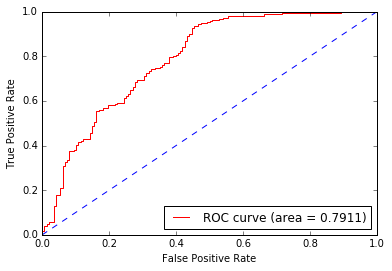

In [11]:
preds = loan_model.predict_proba(logreg_train_feature)[:,1]
fpr, tpr, thres = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [12]:
#prepare output for test data
#Processing test datasets
  #1.create dummy variables
test=pd.read_csv('test_data.csv')
dummies = pd.get_dummies(test['Property_Area'], prefix='Property_Area')
test_recode=test.join(dummies).drop(['Property_Area','Property_Area_Rural'],1)

  #2. recode categorical variables
test_recode['Gender_coded']=coding(test_recode['Gender'],{'Male':0,'Female':1})
test_recode['Married_coded']=coding(test_recode['Married'],{'Yes':0,'No':1})
test_recode['Education_coded']=coding(test_recode['Education'],{'Not Graduate':0,'Graduate':1})
test_recode['Self_Employed_coded']=coding(test_recode['Self_Employed'],{'Yes':0,'No':1})
test_recode['Dependents_coded']=coding(test_recode['Dependents'],{'0':0,'1':1,'2':2,'3+':3})
test_recode.head()

  #3.Delete missing values.
test_recode2= test_recode[(test_recode.apply(num_missing,axis=1)==0)]

  #4. Making prediction using fitted logistic regression model
logreg_test_feature=test_recode2.drop(['Loan_ID','Gender','Married','Education','Self_Employed','Dependents'],1)
py=loan_model.predict(logreg_test_feature)
test_recode2['Loan_Status']=py

  #merge back to original test data set
final_test_all=test.merge(test_recode2.loc[:,['Loan_ID','Loan_Status']],how='outer',on='Loan_ID')

#print final_test_all.shape
x=final_test_all[final_test_all['Loan_Status'].isnull()]
print x.shape
y=final_test_all[final_test_all['Loan_Status'].isnull()==False]
print y.shape

#Since credit history is an importance indicator; Thus, assign loan_status=y if credit history=1 otherwise "N"
#This is very arbitrary.
x['Loan_Status']=np.where(x['Credit_History']>0,'Y','N')
print x.apply(num_missing,axis=0)
print display(x.head())

#concatenate x and y
a1=x.loc[:,['Loan_ID','Loan_Status']]
a2=y.loc[:,['Loan_ID','Loan_Status']]
submission=pd.concat([a1,a2]).sort_values(['Loan_ID'])

print submission.shape
print display(submission.head(5))
print submission.apply(num_missing,axis=0)
submission.to_csv('test_result_0302',header=True,index = False)


(78, 13)
(289, 13)
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
Loan_Status           0
dtype: int64


/Users/xiaohui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xiaohui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,N
8,LP001059,Male,Yes,2,Graduate,NaN,13633,0,280.0,240.0,1.0,Urban,Y
11,LP001082,Male,Yes,1,Graduate,NaN,2185,1516,162.0,360.0,1.0,Semiurban,Y
12,LP001083,Male,No,3+,Graduate,No,4166,0,40.0,180.0,NaN,Urban,N
13,LP001094,Male,Yes,2,Graduate,NaN,12173,0,166.0,360.0,0.0,Semiurban,N


None
(367, 2)


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,N
4,LP001051,Y


None
Loan_ID        0
Loan_Status    0
dtype: int64


Testing final score using logistic regression is 0.756(accuracy on train data set is 0.8125)

Next step: (1) perform imputation to see if accuracy can be improved.
           (2) try random forest model.